In [3]:
import torch
import matplotlib.pyplot as plt
from math import *

# Part 1: Generating the Data
### Problem 1
Write a function that takes as input a number of data points $N$, and gives as output a data matrix $X$ as a PyTorch tensor, with $N$ rows and $100$ columns, where each row is an $x$ vector as above, as well as a PyTorch tensor $y$ with $N$ rows and $1$ column, where each entry of $y$ is the corresponding $y$ value for that row of $X$

In [4]:
def generate_vec_and_label():
    vec = torch.ones(101)
    for i in range(1,51):
        vec[i] = torch.randn(1)
    for i in range(51,61):
        vec[i] = vec[1] + 0.5*vec[i-50] + torch.normal(mean=0,std=0.1,size=(1,1))
    for i in range(61,71):
        vec[i] = vec[i-60] - vec[i-50] + vec[i-40] + torch.normal(mean=0,std=0.1,size=(1,1))
    for i in range(71,81):
        vec[i] = vec[6*(i-70)] + 3*vec[i-70] + torch.normal(mean=0,std=0.1,size=(1,1))
    for i in range(81,91):
        vec[i] = 5 - vec[i-10]
    for i in range(91,101):
        vec[i] = 0.5*vec[50+4*(i-90)] + 0.5*vec[50+3*(i-90)] + torch.normal(mean=0,std=0.1,size=(1,1))
    label = sum(((-0.88)**i) * vec[2*i] for i in range(1,51)) + torch.normal(mean=0,std=0.01,size=(1,1))
    return vec, label

def generate_data(N: int) -> tuple[torch.Tensor, torch.Tensor]:
    X, y = torch.zeros(N,101), torch.zeros(N,1)
    for i in range(N):
        x_vec, y_label = generate_vec_and_label()
        X[i] = x_vec
        y[i] = y_label
    return X, y

# Part 2: Fitting a Linear Model
### Problem 2

In [5]:
def model_f(X: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    return torch.matmul(X, w)               # X == matrix N x d,       w == vector d x 1

def calculate_loss(y_exp: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(y_exp - y_pred))

def generate_random_model(dims):
    return torch.normal(0, 0.01, size=(dims,1))

### Problem 3

In [6]:
def grad_descent(train_set: tuple[torch.Tensor, torch.Tensor], test_set: tuple[torch.Tensor, torch.Tensor], stepsize: float, init_w: torch.Tensor) -> tuple[torch.Tensor,...]:
    X_train, y_train = train_set                            # X is a dataset N x d, y is a vector N x 1
    X_test, y_test = test_set

    train_loss_list = []
    test_loss_list = []

    curr_train_loss = 1
    prev_train_loss = 0

    w = init_w.clone().requires_grad_(True)
    while abs(curr_train_loss - prev_train_loss) > 0.0001 or len(train_loss_list) > 8_000:
        # calculate y_pred based on X and w
        y_train_pred = model_f(X_train, w)
        y_test_pred = model_f(X_test, w)

        # calculate loss for train and test splits and add to list
        prev_train_loss = curr_train_loss
        curr_train_loss = calculate_loss(y_train, y_train_pred)
        test_loss = calculate_loss(y_test, y_test_pred)

        train_loss_list.append(curr_train_loss.item())
        test_loss_list.append(test_loss.item())

        # compute gradients
        curr_train_loss.backward()
        # update params
        with torch.no_grad():
            w.data -= stepsize * w.grad.data
        # zero gradients
        w.grad.data.zero_()

    train_loss_list = torch.FloatTensor(train_loss_list)
    test_loss_list = torch.FloatTensor(test_loss_list)
    return w, train_loss_list, test_loss_list

We have two options to realistically end our training loop:
1. choose a sufficiently large number of iterations $n$ to run the algorithm.
2. run the algorithm until the change in our parameter vector $w$ is less than some threshold $\delta$. This can be modeled by the change in loss, i.e. run the algorithm until $|L(w_{k+1}) - L(w_k)| < \delta$.

We choose the second approach, to ensure that we actually reach convergence for each of our training.

### Problem 4

In [7]:
# generate train/test data:
train_set_size, test_set_size = 1_000, 200

train_set = generate_data(train_set_size)
test_set = generate_data(test_set_size)

print(train_set[0].shape, train_set[1].shape)
print(test_set[0].shape, test_set[1].shape)

init_w = generate_random_model(train_set[0].shape[1])   # w is a vector d x 1; should we start w at 0 or at a random point?

torch.Size([1000, 101]) torch.Size([1000, 1])
torch.Size([200, 101]) torch.Size([200, 1])


In [8]:
# run GD:
stepsize = 0.0001
w, train_loss_list, test_loss_list = grad_descent(train_set, test_set, stepsize, init_w)

diverge_stepsize = 0.01
diverge_w, diverge_train_list, diverge_test_list = grad_descent(train_set, test_set, diverge_stepsize, init_w)

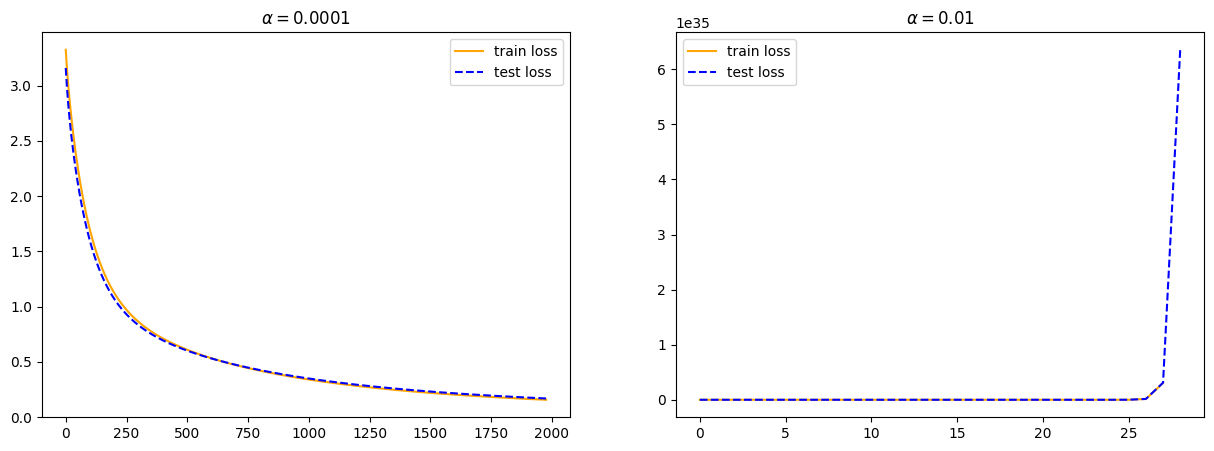

In [9]:
# plot results
plt.figure(figsize=(15,5))

# train loss plot
plt.subplot(121)
plt.plot(train_loss_list, color='orange', linestyle='solid', label='train loss')
plt.plot(test_loss_list, color='b', linestyle='dashed', label='test loss')
plt.title(rf"$\alpha = ${stepsize}")
plt.legend()

# test loss plot
plt.subplot(122)
plt.plot(diverge_train_list, color='orange', linestyle='solid', label='train loss')
plt.plot(diverge_test_list, color='b', linestyle='dashed', label='test loss')
plt.legend()
plt.title(rf"$\alpha = ${diverge_stepsize}")

plt.show()

In [10]:
actual_model = torch.zeros(101, dtype=torch.float64)
for k in range(2, 101, 2):
    actual_model[k] = (-0.88)**(k/2)

print(torch.linalg.vector_norm(actual_model - w))

tensor(19.2752, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)



- What range of $\alpha$ lead to convergence, what don’t? How can you tell that an $\alpha$ is too large?
    - We see that, for large $\alpha \geq 10^{-2}$, the loss actually increases and converges to +inf. This means that the $\alpha$ is too large and the points we are selecting on the function overstep the local minimum we are trying to converge to.


- For an $\alpha$ with convergence, plot the loss on the training data and the loss on the testing data as a function of training time. How do the training and testing error compare over time? Is the model learning?
    - Above is a plot with $\alpha = 10^{-4}$. As we can see, both the loss over the training set and the test set decreases wrt to time. This suggests that the model is learning to detect patterns in the training data, and it carries over well to the test data.

- For a good α, trained to convergence - does the resulting model generalize to the testing data well?
    - As mentioned above, the resulting model is generalizing to the testing data well. The loss of the train and test sets are almost identical.

- How does the fit model compare to the ‘actual’ model?
    - The 'actual' model is the vector $w = (0,0,-0.88, 0, (-0.88)^2, \dots 0, (-0.88)^{50})$. Taking the L2 norm of the difference between the actual model $w$ and the fitted model using GD, $\hat{w}$, we get $\|w - \hat{w}\| \approx 2$, which is quite low for a vector of dimension 101. Therefore, we can reasonably assume that the fit model is quite close to the 'actual' model.

### Problem 5

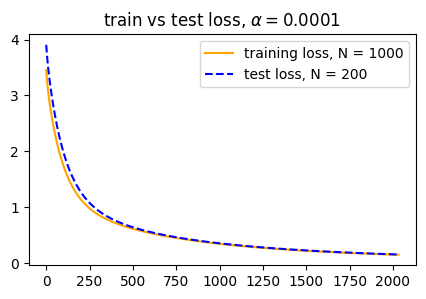

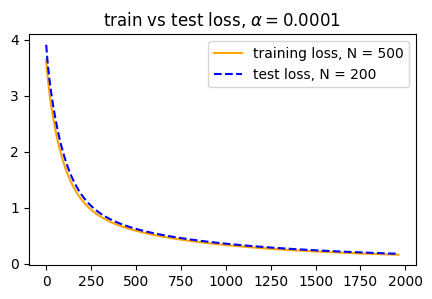

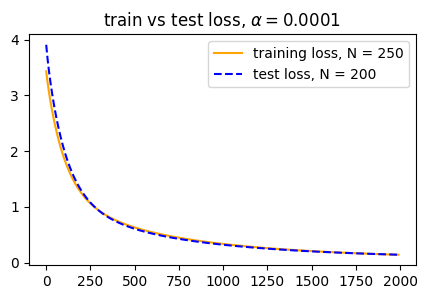

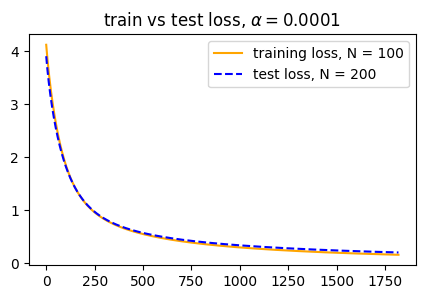

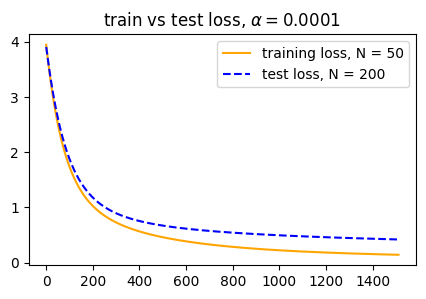

In [11]:
list_N = [1000, 500, 250, 100, 50]

test_set_size = 200
test_set = generate_data(test_set_size)

for i,N in enumerate(list_N):
    train_set = generate_data(N)
    w, train_loss_list, test_loss_list = grad_descent(train_set, test_set, stepsize, init_w)
    # plot results
    plt.figure(figsize=(5,3))

    # train loss plot
    plt.plot(train_loss_list, color='orange', linestyle='solid', label=f'training loss, N = {N}')

    # test loss plot
    plt.plot(test_loss_list, color='b', linestyle='dashed', label=f'test loss, N = 200')
    plt.title(rf"train vs test loss, $\alpha = ${stepsize}")
    plt.legend()

    plt.show()

As $N_{train}$ gets small compared to $N_{test}$, we see that the model generalizes relatively poorly to the test set. We can see that, for smaller $N$, the path of the training loss is the same, albeit shifted in the y-direction by some amount (some of this can be attributed to chance). This means that, for small training set sizes, the model cannot perform well on a relatively larger test set.

# Part 3: Regularization: Ridge and Lasso

**Regularization Bonus**: Why is it worth keeping $w_0$ out of the regularization penalty terms?
- Since $x_0 = 1$ is a constant for all data in our dataset, $w_0$ changes the "y-intercept" of our regression line/hyperplane. If we add a penalty to $w_0$ being large, it may prevent us from optimally fitting $w_0$ to the optimal y-intercept, as the y-intercept may not always be 0.

In [12]:
def ridge_loss(y_exp, y_pred, w, reg_param):
    return calculate_loss(y_exp, y_pred) + reg_param * sum(w[i]**2 for i in range(1, len(w)))

def lasso_loss(y_exp, y_pred, w, reg_param):
    return calculate_loss(y_exp, y_pred) + reg_param * sum(abs(w[i]) for i in range(1, len(w)))

"""
returns optimal w*, and two lists.
train_loss_list is a list of REGULARIZED training losses (includes ridge parameter)
test_loss_list is a list of UNREGLUARIZED testing losses (does not include ridge parameter)
"""
def ridge_regression(train_set, test_set, stepsize, reg_param, init_w):
    X_train, y_train = train_set
    X_test, y_test = test_set

    train_loss_list, test_loss_list = [], []

    curr_train_loss, prev_train_loss = 1, 0

    w = init_w.clone().requires_grad_(True)
    while abs(curr_train_loss - prev_train_loss) > 0.0001:
        y_train_pred, y_test_pred = model_f(X_train, w), model_f(X_test, w)
        test_loss = calculate_loss(y_test, y_test_pred)
        prev_train_loss = curr_train_loss
        curr_train_loss = ridge_loss(y_train, y_train_pred, w, reg_param)

        train_loss_list.append(curr_train_loss)
        test_loss_list.append(test_loss)

        curr_train_loss.backward()
        with torch.no_grad():
            w.data -= stepsize * w.grad.data
        w.grad.data.zero_()
    return w, torch.FloatTensor(train_loss_list), torch.FloatTensor(test_loss_list)

def lasso_regression(train_set, test_set, stepsize, reg_param, init_w):
    X_train, y_train = train_set
    X_test, y_test = test_set

    train_loss_list, test_loss_list = [], []

    curr_train_loss, prev_train_loss = 1, 0

    w = init_w.clone().requires_grad_(True)
    while abs(curr_train_loss - prev_train_loss) > 0.0001:
        y_train_pred, y_test_pred = model_f(X_train, w), model_f(X_test, w)
        test_loss = calculate_loss(y_test, y_test_pred)
        prev_train_loss = curr_train_loss
        curr_train_loss = lasso_loss(y_train, y_train_pred, w, reg_param)

        train_loss_list.append(curr_train_loss)
        test_loss_list.append(test_loss)

        curr_train_loss.backward()
        with torch.no_grad():
            w.data -= stepsize * w.grad.data
        w.grad.data.zero_()
    return w, torch.FloatTensor(train_loss_list), torch.FloatTensor(test_loss_list)

### Problem 6

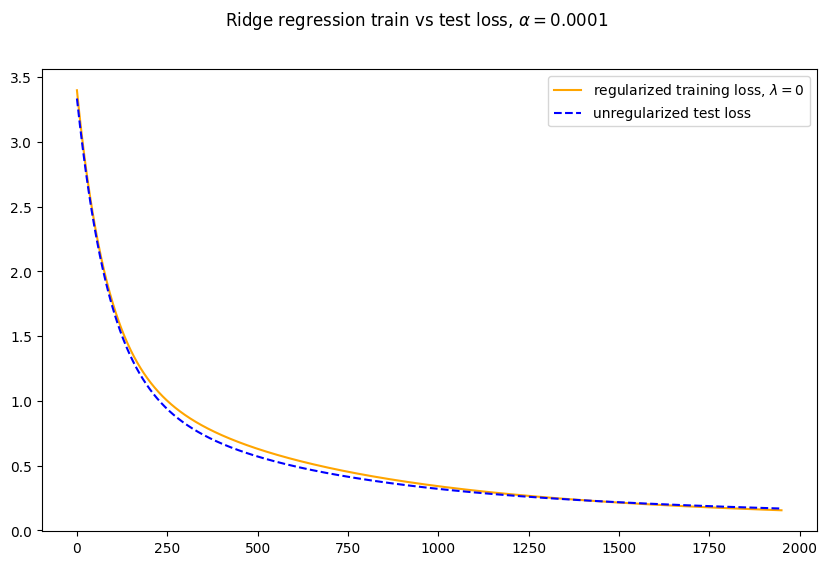

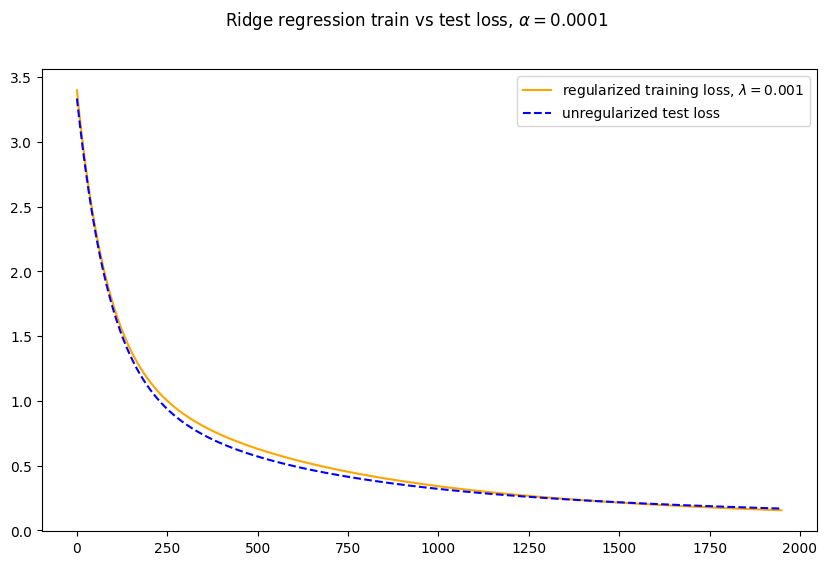

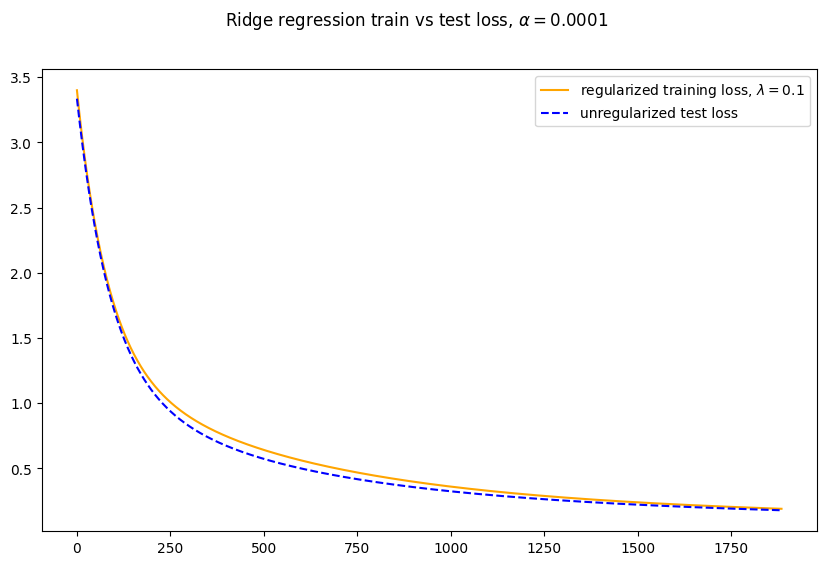

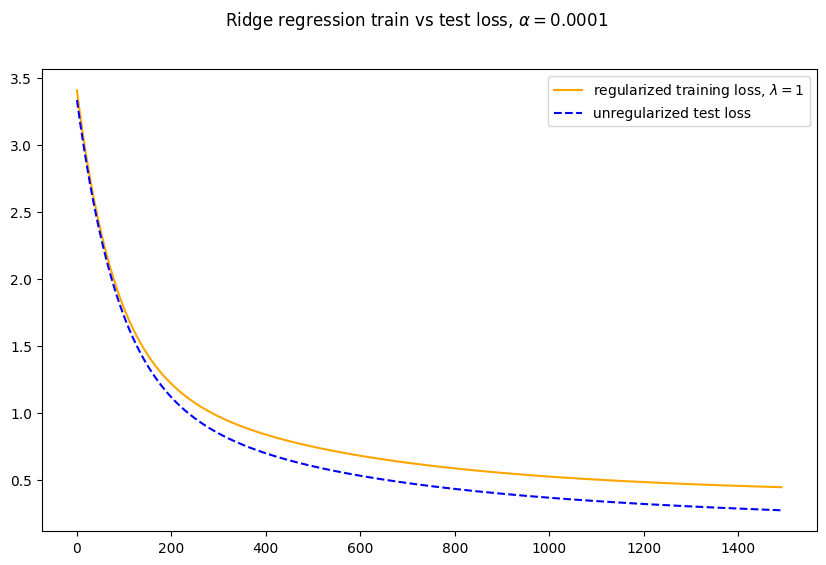

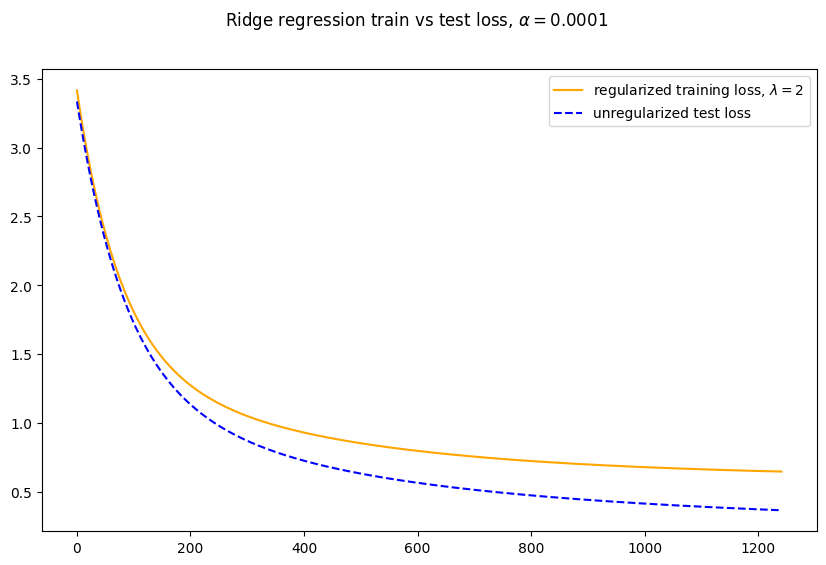

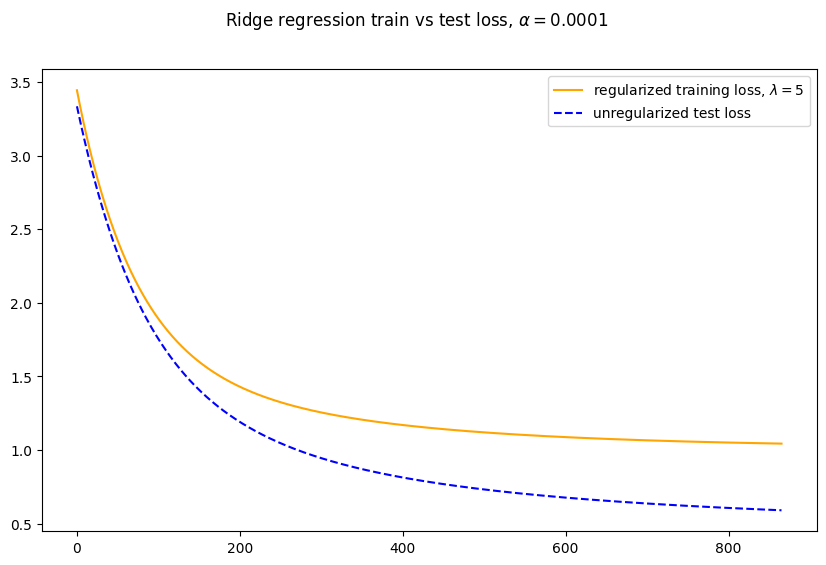

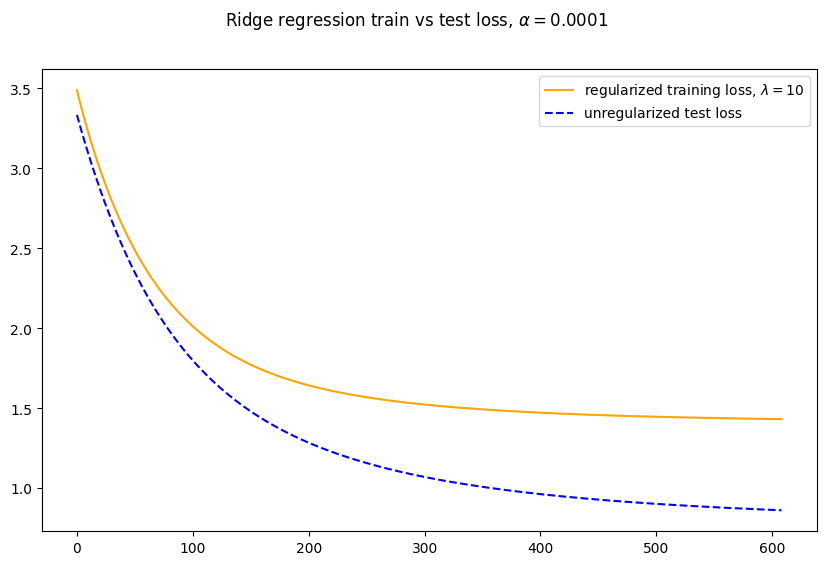

In [13]:
train_set_size, test_set_size = 300, 200

reg_params = [0, 0.001, 0.1, 1, 2, 5, 10]

train_set = generate_data(train_set_size)
test_set = generate_data(test_set_size)
init_w = generate_random_model(train_set[0].shape[1])
stepsize = 0.0001

for reg in reg_params:
    plt.figure(figsize=(10,6))
    w, train_loss_list, test_loss_list = ridge_regression(train_set, test_set, stepsize, reg, init_w)
    # plot results

    # train loss plot
    plt.plot(train_loss_list, color='orange', linestyle='solid', label=rf'regularized training loss, $\lambda = ${reg}')

    # test loss plot
    plt.plot(test_loss_list, color='b', linestyle='dashed', label='unregularized test loss')
    plt.suptitle(rf"Ridge regression train vs test loss, $\alpha = ${stepsize}")
    plt.legend()
    plt.show()

It seems like a range of $\lambda \in (0, 2]$ is most useful for improving generalization of the model. We can see that the model generalizes better in this region because the test loss becomes significantly lower than the training loss. This is due to the ridge parameter reducing the model complexity by adding downward pressure on the magnitude of model weights. The best parameter seems to be $\lambda = 0.1$. Interestingly, it also takes the model fewer iterations to reach convergence when given a higher $\lambda$.

### Problem 7:

In [14]:
train_set_size, test_set_size = 300, 200

reg_params = [0, 0.001, 0.1, 1, 2, 5, 10]

train_set = generate_data(train_set_size)
test_set = generate_data(test_set_size)
init_w = generate_random_model(train_set[0].shape[1])
stepsize = 1e-7        # lower stepsize to allow for more consistent downward pressure

zero_cts = {}
when_i_to_zero = [20] * 101

for reg in reg_params:
    w, train_loss_list, test_loss_list = lasso_regression(train_set, test_set, stepsize, reg, init_w)

    # bool_vec[i] is False iff w[i] is zero
    bool_vec = torch.abs(w) >= 1e-4
    for i in range(len(bool_vec)):
        if bool_vec[i] == False and when_i_to_zero[i] > 10: # this element has just been zeroed
            when_i_to_zero[i] = reg

    zero_cts[reg] = torch.sum(bool_vec).item()

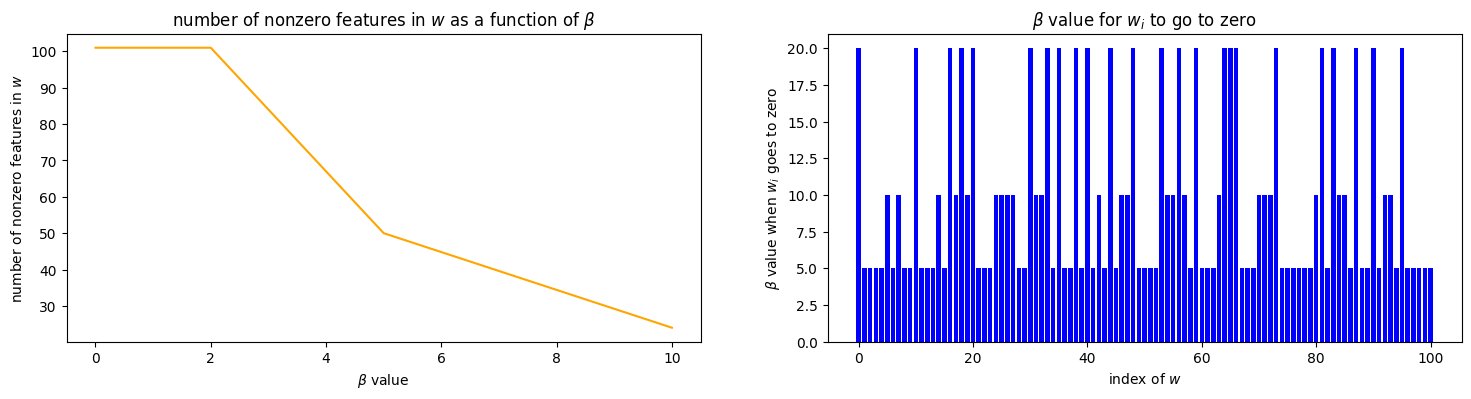

indices that survived all rounds: 
[0, 10, 16, 18, 20, 30, 33, 35, 38, 40, 44, 48, 53, 56, 59, 64, 65, 66, 73, 81, 83, 87, 90, 95]


In [15]:
plt.figure(figsize=(18,4))

plt.subplot(121)
plt.plot(zero_cts.keys(), zero_cts.values(), color='orange', linestyle = 'solid', label=r'number of nonzero features in $w$')
plt.xlabel(r'$\beta$ value')
plt.ylabel(r'number of nonzero features in $w$')
plt.title(r'number of nonzero features in $w$ as a function of $\beta$')

plt.subplot(122)
plt.bar(range(101),when_i_to_zero, color='b')
plt.xlabel(r'index of $w$')
plt.ylabel(r'$\beta$ value when $w_i$ goes to zero')
plt.title(r'$\beta$ value for $w_i$ to go to zero')
plt.show()

surviving_indices = []
print(f'indices that survived all rounds: ')
for i in range(len(when_i_to_zero)):
    if when_i_to_zero[i] > 10:
        surviving_indices.append(i)
print(surviving_indices)

As we see in the first graph, using a small stepsize $\alpha = 10^{-7}$, the number of nonzero features in $w$ goes down as $\beta$ increases. We do not see any effect on the L1 norm when $\beta \leq 2$, it seems like, for this particular dataset, a higher $\beta \approx 5$ is required to see terms go to zero. We know that the odd-indexed features of $x$ never explicitly show up in the value of $y$, so we should expect that they would be the first terms to be selected to go to zero. This idea is somewhat in-line with what we see in our barchart, with mostly (large) even-indexed values of $w$ surviving even when $\beta = 10$.

**Bonus**: the Lasso/L1-norm regularizer is not differentiable, but it is convex. PyTorch uses the subgradient, which is well-defined for convex functions, to provide a reasonable extension of the gradient of L1-norm where it is not defined. More specifically, PyTorch uses automatic/algorithmic differentiation (AD) for all of its gradient computation methods, but uses either the subgradient or continuity to extend the gradient when a function is not defined at a single point.

# Part 4: Under-Parameterization and Over-Parameterization

Sometimes we may have fewer data points than we have features - this makes it difficult to determines how the underlying model should depend on each feature. We just don't have enough data. In the following problems, consider a training data set of size $N=50$ and a test data set of size $N=50$.

### Problem 8

In [16]:
def generate_matA(k):
    return torch.randn((k, 101))

In [17]:
X_train, y_train = generate_data(50)
X_test, y_test = generate_data(50)

stepsize = 1e-6
num_samplepaths = 10

final_train_losses, final_test_losses, final_train_cycles = [], [], []

for k in range(1, 51):
    train_losses, test_losses, num_train_cycles = [], [], []

    for n in range(num_samplepaths):
        A = generate_matA(k)
        transformed_X_train = torch.matmul(X_train, A.t())        # X is an input of 50x101, A is an input of Kx101 --> want 50xK --> XA^T
        transformed_X_test = torch.matmul(X_test, A.t())
        transformed_train_set = transformed_X_train, y_train
        transformed_test_set = transformed_X_test, y_test

        init_w = generate_random_model(k)

        w, train_loss_list, test_loss_list = grad_descent(transformed_train_set, transformed_test_set, stepsize, init_w)
        train_losses.append(train_loss_list[-1])
        test_losses.append(test_loss_list[-1])
        num_train_cycles.append(len(train_loss_list))

    mean_train_loss = torch.mean(torch.FloatTensor(train_losses)).item()
    mean_test_loss = torch.mean(torch.FloatTensor(test_losses)).item()
    mean_train_cycles = torch.mean(torch.FloatTensor(num_train_cycles)).item()

    final_train_losses.append(mean_train_loss)
    final_test_losses.append(mean_test_loss)
    final_train_cycles.append(mean_train_cycles)

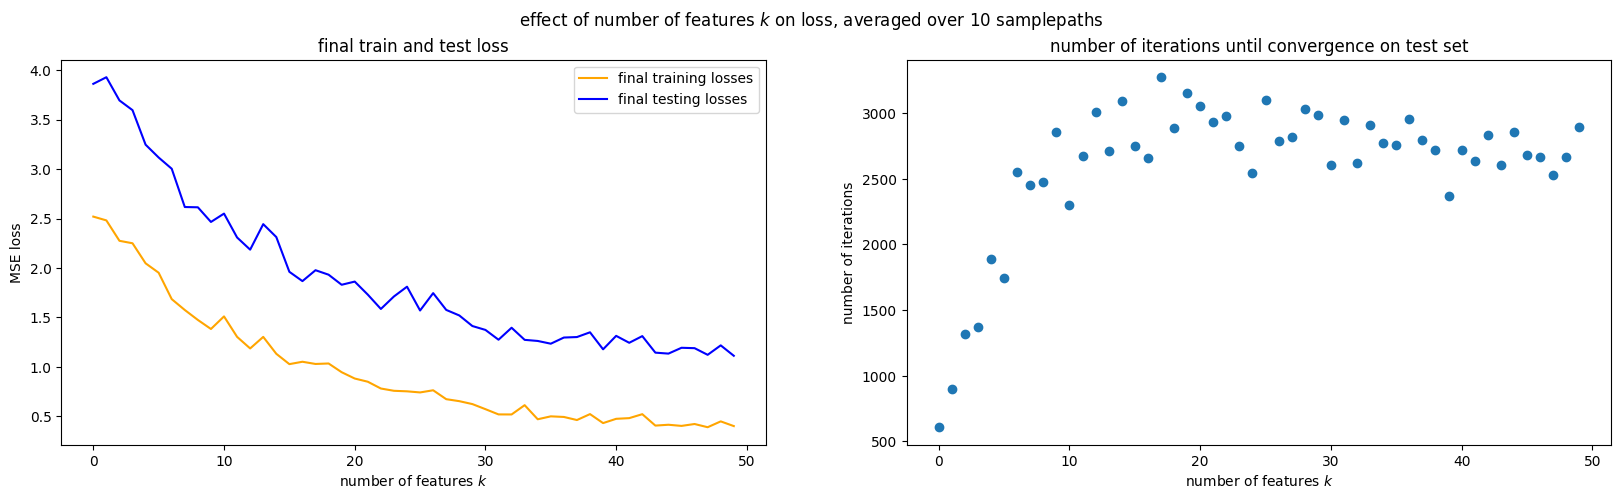

In [18]:
plt.figure(figsize=(20,5))
plt.suptitle(rf'effect of number of features $k$ on loss, averaged over {num_samplepaths} samplepaths')

plt.subplot(121)
plt.plot(final_train_losses, color='orange', linestyle = 'solid', label=r'final training losses')
plt.plot(final_test_losses, color='b', label='final testing losses')
plt.xlabel(r'number of features $k$')
plt.ylabel(r'MSE loss')
plt.legend()
plt.title(r'final train and test loss')

plt.subplot(122)
plt.scatter(range(len(final_train_cycles)), final_train_cycles)
plt.title(r'number of iterations until convergence on test set')
plt.ylabel('number of iterations')
plt.xlabel(r'number of features $k$')
plt.show()

In this problem, we take the average final train/test losses over 10 samplepaths. We can see that, as the number of features increases, both the train and test losses tend to decrease. This seems to be a reasonable trend, as we can guess that the additional features can allow the model to fit better to the data. This is certainly true for the training data, as more features will give the model more variables to fit our regression line to. We can also see that the testing losses do not decrease as quickly as the training loss; this is because the model is being fit to the training data only and cannot see the testing data performance. We do not see overfitting yet (the testing loss is not increasing over $k$), but it is likely that we will encounter an increase in loss in the next problem.

What is also interesting is the number of iterations needed to converge. We can see that, for a low number of features, we reach convergence quickly. For large number of features, past $k > 10$, there is relatively little effect on the number of features w.r.t. convergence time. This again could be related to the connection between number of features and model fitting: for lower feature count, it may be easier for the model to reach a local optima, as there are fewer variables (dimensions) to balance.

### Problem 9

In [19]:
def short_ridge_regression(train_set, test_set, stepsize, reg_param, init_w):
    X_train, y_train = train_set
    X_test, y_test = test_set

    train_loss_list, test_loss_list = [], []

    curr_train_loss, prev_train_loss = 1, 0

    w = init_w.clone().requires_grad_(True)
    # for time issues, we lower the threshold needed for termination, and also place a (low) restriction on the max number of iterations
    # this is not ideal, but unbounded runs of ridge regression took over 1 hour.
    while abs(curr_train_loss - prev_train_loss) > 0.005 and len(train_loss_list) < 400:
        y_train_pred, y_test_pred = model_f(X_train, w), model_f(X_test, w)
        test_loss = calculate_loss(y_test, y_test_pred)
        prev_train_loss = curr_train_loss
        curr_train_loss = ridge_loss(y_train, y_train_pred, w, reg_param)

        train_loss_list.append(curr_train_loss)
        test_loss_list.append(test_loss)

        curr_train_loss.backward()
        with torch.no_grad():
            w.data -= stepsize * w.grad.data
        w.grad.data.zero_()
    return w, torch.FloatTensor(train_loss_list), torch.FloatTensor(test_loss_list)

In [20]:
X_train, y_train = generate_data(50)
X_test, y_test = generate_data(50)

stepsize = 1e-6
num_samplepaths = 5

final_train_losses, final_test_losses, final_train_cycles = [], [], []
for k in range(50, 200):
    train_losses, test_losses, num_train_cycles = [], [], []

    for n in range(num_samplepaths):
        A = generate_matA(k)
        transformed_X_train = torch.matmul(X_train, A.t())        # X is an input of 50x101, A is an input of Kx101 --> want 50xK --> XA^T
        transformed_X_test = torch.matmul(X_test, A.t())
        transformed_train_set = transformed_X_train, y_train
        transformed_test_set = transformed_X_test, y_test

        init_w = generate_random_model(k)

        w, train_loss_list, test_loss_list = short_ridge_regression(transformed_train_set, transformed_test_set, stepsize, 0, init_w)
        train_losses.append(train_loss_list[-1])
        test_losses.append(test_loss_list[-1])
        num_train_cycles.append(len(train_loss_list))

    mean_train_loss = torch.mean(torch.FloatTensor(train_losses)).item()
    mean_test_loss = torch.mean(torch.FloatTensor(test_losses)).item()
    mean_train_cycles = torch.mean(torch.FloatTensor(num_train_cycles)).item()

    final_train_losses.append(mean_train_loss)
    final_test_losses.append(mean_test_loss)
    final_train_cycles.append(mean_train_cycles)

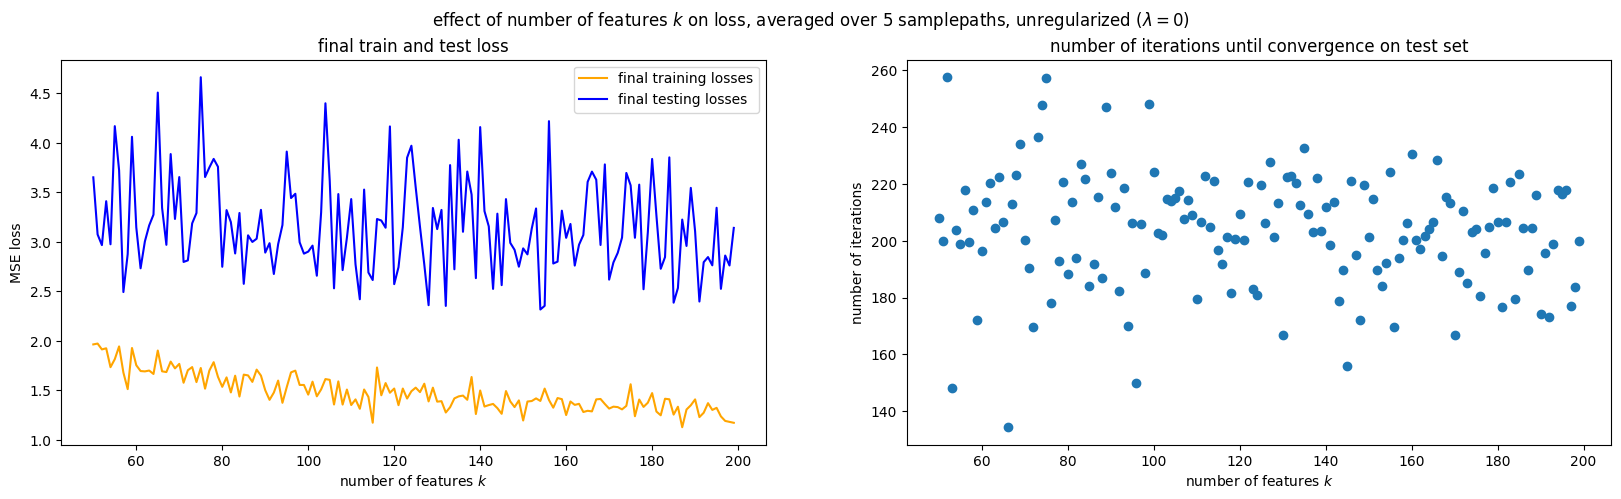

In [21]:
plt.figure(figsize=(20,5))
plt.suptitle(rf'effect of number of features $k$ on loss, averaged over {num_samplepaths} samplepaths, unregularized ($\lambda = 0$)')

plt.subplot(121)
plt.plot(range(50, 50+len(final_train_losses)), final_train_losses, color='orange', linestyle = 'solid', label=r'final training losses')
plt.plot(range(50, 50+len(final_train_losses)), final_test_losses, color='b', label='final testing losses')
plt.xlabel(r'number of features $k$')
plt.ylabel(r'MSE loss')
plt.legend()
plt.title(r'final train and test loss')

plt.subplot(122)
plt.scatter(range(50, 50+len(final_train_cycles)), final_train_cycles)
plt.title(r'number of iterations until convergence on test set')
plt.ylabel('number of iterations')
plt.xlabel(r'number of features $k$')

plt.show()

In [22]:
final_train_losses, final_test_losses, final_train_cycles = [], [], []
for k in range(50, 200):
    train_losses, test_losses, num_train_cycles = [], [], []

    for n in range(num_samplepaths):
        A = generate_matA(k)
        transformed_X_train = torch.matmul(X_train, A.t())        # X is an input of 50x101, A is an input of Kx101 --> want 50xK --> XA^T
        transformed_X_test = torch.matmul(X_test, A.t())
        transformed_train_set = transformed_X_train, y_train
        transformed_test_set = transformed_X_test, y_test

        init_w = generate_random_model(k)

        w, train_loss_list, test_loss_list = short_ridge_regression(transformed_train_set, transformed_test_set, stepsize, 2, init_w)
        train_losses.append(train_loss_list[-1])
        test_losses.append(test_loss_list[-1])
        num_train_cycles.append(len(train_loss_list))

    mean_train_loss = torch.mean(torch.FloatTensor(train_losses)).item()
    mean_test_loss = torch.mean(torch.FloatTensor(test_losses)).item()
    mean_train_cycles = torch.mean(torch.FloatTensor(num_train_cycles)).item()

    final_train_losses.append(mean_train_loss)
    final_test_losses.append(mean_test_loss)
    final_train_cycles.append(mean_train_cycles)

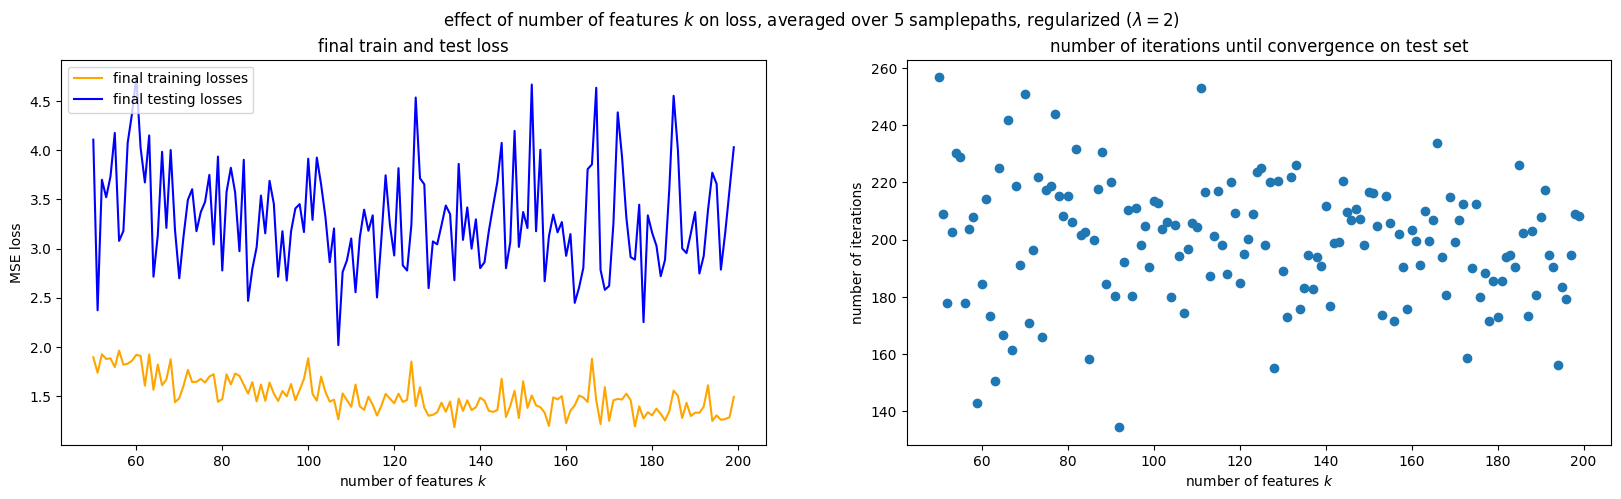

In [23]:
plt.figure(figsize=(20,5))
plt.suptitle(rf'effect of number of features $k$ on loss, averaged over {num_samplepaths} samplepaths, regularized ($\lambda = 2$)')

plt.subplot(121)
plt.plot(range(50, 50+len(final_train_losses)), final_train_losses, color='orange', linestyle = 'solid', label=r'final training losses')
plt.plot(range(50, 50+len(final_train_losses)), final_test_losses, color='b', label='final testing losses')
plt.xlabel(r'number of features $k$')
plt.ylabel(r'MSE loss')
plt.legend()
plt.title(r'final train and test loss')

plt.subplot(122)
plt.scatter(range(50, 50+len(final_train_cycles)), final_train_cycles)
plt.title(r'number of iterations until convergence on test set')
plt.ylabel('number of iterations')
plt.xlabel(r'number of features $k$')

plt.show()

Over multiple tests of $\lambda$, we settle a ridge regression parameter of $\lambda = 2$ as this was a well-performing parameter for most $k$ (compared to $\lambda \neq 2$). Note that $\lambda = 2$ was a high choice of regularization parameter in earlier tests, and did not perform optimally (problem 7).

Overall, we see that there is a small improvement in using $\lambda = 2$ vs an unregularized problem ($\lambda = 0$). Most obvious is that, when solving the unregularized problem, there is a slight upward trend in the test loss as $k$ increases. On the other hand, the testing loss in the regularized problem seems to stay relative stable as $k$ increases. There are many spikes and jumps in the graphs for both regularized and unregularized problems, but this can be solved by averaging over more samplepaths or taking a tighter convergence threshold (I chose not to do this in order to keep the runtime reasonable).

As a whole, $\lambda$ should tend to increase as the number of features $k$ increases. When we have significantly more features than datapoints, a lot of these features can be attributed to noise. Increasing $\lambda$ will discourage our model from fitting to these noisy features (which vastly outnumber the useful features) and allow for better fitting without overfit.